In [1]:
import pandas as pd
import numpy as np
import pytesseract
from pytesseract import Output
import PIL.Image
import cv2
import re

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head(10)

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram
5,https://m.media-amazon.com/images/I/61QsBSE7jg...,731432,item_weight,1400 milligram
6,https://m.media-amazon.com/images/I/81xsq6vf2q...,731432,item_weight,1400 milligram
7,https://m.media-amazon.com/images/I/71DiLRHeZd...,731432,item_weight,1400 milligram
8,https://m.media-amazon.com/images/I/91Cma3Rzse...,731432,item_weight,1400 milligram
9,https://m.media-amazon.com/images/I/71jBLhmTNl...,731432,item_weight,1400 milligram


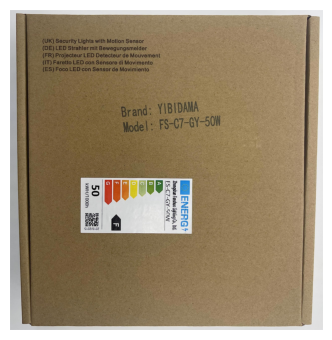

In [4]:
from skimage import io
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

idx = 6

f = df['image_link'][idx]

f = 'https://m.media-amazon.com/images/I/91mAaKY+tkL.jpg'

a = io.imread(f)

plt.imshow(a)
plt.axis('off')

plt.show()

In [5]:
import pandas as pd
import numpy as np
import re
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
import pytesseract
from skimage import io

# Entity unit map with corresponding unit categories
entity_unit_map = {
    'item_weight': {'g', 'gram', 'kilogram', 'kg', 'milligram', 'mg', 'ounce', 'oz', 'pound', 'lb'},
    'width': {'cm', 'inch', 'mm', 'meter', 'm', 'foot', 'ft'},
    'depth': {'cm', 'inch', 'mm', 'meter', 'm', 'foot', 'ft'},
    'height': {'cm', 'inch', 'mm', 'meter', 'm', 'foot', 'ft'},
    'voltage': {'volt', 'v'},
    'wattage': {'watt', 'w'},
    'item_volume': {'ml', 'litre', 'cup', 'gallon'},
    'maximum_weight_recommendation': {'g', 'gram', 'kilogram', 'kg', 'milligram', 'mg', 'ounce', 'oz', 'pound', 'lb'},
}

# Unit hierarchy for comparison (e.g., kg > g > mg)
unit_hierarchy = {
    'kg': 1000,
    'g': 1,
    'mg': 0.001,
    'lb': 453.592,  # 1 lb = 453.592 g
    'oz': 28.3495,  # 1 oz = 28.3495 g
}

def add_missing_decimal(match):
    """Corrects missing leading zeros in values like '051g' -> '0.51g'."""
    number, unit = re.findall(r"(\d+)(\w+)", match)[0]
    if len(number) > 2 and number.startswith("0"):
        return f"0.{number[1:]}{unit}"
    return match

def compare_units(val1, val2):
    """Compares two unit values (e.g., 500g and 0.5kg)."""
    value1, unit1 = re.findall(r"(\d+(\.\d+)?)(\w+)", val1)[0][:2]
    value2, unit2 = re.findall(r"(\d+(\.\d+)?)(\w+)", val2)[0][:2]

    # Convert both to the base unit (grams for weight) for comparison
    value1_in_g = float(value1) * unit_hierarchy.get(unit1, 1)
    value2_in_g = float(value2) * unit_hierarchy.get(unit2, 1)

    return val1 if value1_in_g > value2_in_g else val2

def extract_and_filter_units(image_link, entity_name, entity_value):
    try:
        # Open image from URL using skimage.io
        img = Image.fromarray(io.imread(image_link))  # Convert NumPy array to PIL Image

        # Convert image to grayscale, enhance sharpness, contrast, and binarize
        img_gray = img.convert('L')  # Convert to grayscale
        img_gray = img_gray.filter(ImageFilter.SHARPEN)

        # Enhance contrast
        enhancer = ImageEnhance.Contrast(img_gray)
        img_enhanced = enhancer.enhance(2.5)  # Increase contrast

        # Apply adaptive thresholding for binarization (convert to black and white)
        img_binarized = ImageOps.autocontrast(img_enhanced)

        # Use Tesseract to extract text
        myconfig = r"--psm 11 --oem 1"
        extracted_text = pytesseract.image_to_string(img_binarized, config=myconfig)

        # Create a regex pattern for detecting units (updated to handle no space between number and unit)
        unit_pattern = r"\b(\d+(?:\.\d+)?\s*(?:cm|inch|mm|g|kg|KG|mg|oz|lb|volt|v|watt|w|ml|l)|\d+(?:\.\d+)?(?:cm|inch|mm|g|kg|KG|mg|oz|lb|volt|v|watt|w|ml|l))\b"

        # Search the text for any units that match the pattern
        matches = re.findall(unit_pattern, extracted_text.lower())

        # Fix missing decimals in matches
        corrected_matches = [add_missing_decimal(match) for match in matches]

        # Filter matches based on the entity_name's allowed units
        filtered_matches = [match for match in corrected_matches if any(unit in match for unit in entity_unit_map[entity_name])]

        # If there are multiple matches, find the largest one
        if filtered_matches:
            largest_match = filtered_matches[0]
            for match in filtered_matches[1:]:
                largest_match = compare_units(largest_match, match)
        else:
            largest_match = None

        return largest_match

    except Exception as e:
        print(f"Error processing image {image_link}: {e}")
        return None

# Initialize a counter
counter = 0
last_percent_printed = -1

# Use only the first 100 rows for processing
subset_df = df.head(10000)
total_images = len(subset_df)

# Apply the function to the subset of the dataset and store the results in a new 'output' column
def process_images(row):
    global counter, last_percent_printed
    result = extract_and_filter_units(row['image_link'], row['entity_name'], row['entity_value'])
    counter += 1
    percent_completed = int((counter / total_images) * 100)
    
    # Print percentage completed at every percent increase
    if percent_completed > last_percent_printed:
        print(f"Completed: {percent_completed}%")
        last_percent_printed = percent_completed
    
    return result

subset_df['output'] = subset_df.apply(process_images, axis=1)

# Function to extract the numeric part from a string, with error handling for None or non-string inputs
def extract_numeric_value(value):
    if not isinstance(value, str):
        return None  # If the value is not a string, return None
    match = re.search(r'\d+(\.\d+)?', value)
    return float(match.group()) if match else None

# Function to compare 'entity_value' and 'output' columns and calculate accuracy
def compare_values(df):
    # Extract numeric values for comparison
    df['entity_value_numeric'] = df['entity_value'].apply(extract_numeric_value)
    df['output_numeric'] = df['output'].apply(extract_numeric_value)

    # Compare the numeric values
    df['is_correct'] = df['entity_value_numeric'] == df['output_numeric']

    # Calculate accuracy
    accuracy = df['is_correct'].mean() * 100  # In percentage
    return accuracy

# Apply the function to calculate and print the accuracy for the subset
accuracy = compare_values(subset_df)
print(f"Accuracy: {accuracy:.2f}%")



Completed: 0%
Error processing image https://m.media-amazon.com/images/I/61BZ4zrjZXL.jpg: list index out of range
Error processing image https://m.media-amazon.com/images/I/61sQ+qAKr4L.jpg: list index out of range
Error processing image https://m.media-amazon.com/images/I/71nywfWZUwL.jpg: list index out of range
Error processing image https://m.media-amazon.com/images/I/71nywfWZUwL.jpg: list index out of range
Error processing image https://m.media-amazon.com/images/I/71E9iF-bmKL.jpg: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>
Error processing image https://m.media-amazon.com/images/I/71ZtDgGX+iL.jpg: list index out of range
Error processing image https://m.media-amazon.com/images/I/612xIhPMHqL.jpg: list index out of range
Completed: 1%
Error processing image https://m.media-amazon.com/images/I/81yG9eUKvxL.jpg: list